In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn import metrics
from pathlib import Path
from sklearn import svm
from osgeo import gdal
import seaborn as sn
import pandas as pd
import numpy as np
import rasterio
import pickle
import cv2

In [2]:
x_pavia_u = loadmat('PaviaU.mat')['paviaU']
y_pavia_u= loadmat('PaviaU_gt.mat')['paviaU_gt']

In [3]:
def normalize(raster, n = 5000):
    raster[raster>n]=n
    min_raster, max_raster, new_max, new_min = raster.min(), raster.max(), 255, 0
    return ((raster-min_raster)*((new_max-new_min)/(max_raster-min_raster))+new_min).astype(int)

(-0.5, 339.5, 609.5, -0.5)

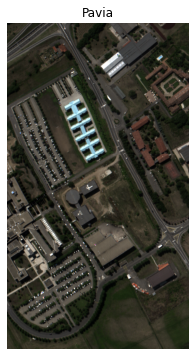

In [4]:
pavia = np.dstack((
    x_pavia_u[:, :, 40], #39
    x_pavia_u[:, :, 30], #30
    x_pavia_u[:, :, 20]  #12
)) 
plt.figure(figsize=(6, 6))
plt.imshow(normalize(pavia))
plt.title("Pavia")
plt.axis('off')

In [5]:
data = x_pavia_u.reshape(-1, x_pavia_u.shape[2])
df_pavia_u = pd.DataFrame(data=data)
df_pavia_u = pd.concat([df_pavia_u, pd.DataFrame(data = y_pavia_u.ravel())], axis=1)
df_pavia_u.columns= [f'band{i}' for i in range(1, 1 + x_pavia_u.shape[2])]+['class']
df_pavia_u.head()

,band1,band2,band3,band4,band5,band6,band7,band8,band9,band10,...,band95,band96,band97,band98,band99,band100,band101,band102,band103,class
0,647,499,464,371,291,319,365,322,296,305,...,3416,3335,3256,3226,3205,3210,3221,3238,3250,0
1,604,546,527,455,378,377,336,314,324,329,...,2583,2538,2509,2511,2501,2468,2442,2464,2528,0
2,621,746,556,360,285,300,274,276,332,319,...,2288,2242,2193,2202,2225,2266,2308,2345,2361,0
3,637,592,482,556,508,284,178,198,193,224,...,2675,2609,2541,2551,2571,2569,2573,2620,2644,0
4,625,560,480,360,377,341,264,208,231,266,...,2392,2344,2289,2328,2415,2424,2386,2431,2456,0


In [6]:
componets = 20
pca_pavia = PCA(n_components = componets)
df_pca = pca_pavia.fit_transform(df_pavia_u.iloc[:, :-1].values)
df_pca = pd.concat([pd.DataFrame(data = df_pca), pd.DataFrame(data = y_pavia_u.ravel())], axis = 1)
df_pca.columns = [f'PCA-{i}' for i in range(1, componets + 1)]+['class']
df_pca.head()

,PCA-1,PCA-2,PCA-3,PCA-4,PCA-5,PCA-6,PCA-7,PCA-8,PCA-9,PCA-10,...,PCA-12,PCA-13,PCA-14,PCA-15,PCA-16,PCA-17,PCA-18,PCA-19,PCA-20,class
0,-5150.190044,6795.052770,1532.351461,410.030134,-259.856157,-832.898971,293.239774,278.385209,-285.609953,251.208595,...,11.785123,92.312014,-9.586732,-59.457366,-62.721970,68.000191,71.474298,-85.893155,-34.026485,0
1,-6082.245760,3158.592195,1463.194744,154.617093,-438.871877,-496.202148,362.925835,187.355459,-287.796853,180.614422,...,-57.699471,75.351808,-18.999480,1.789730,23.908612,69.310616,-6.183399,-1.042040,-60.018377,0
2,-7214.505405,1158.875812,1400.817899,410.044063,38.052916,-560.804196,-140.004201,8.847608,-211.057111,14.139348,...,60.944802,25.537784,39.065956,86.375976,-46.812513,-36.160918,-71.218239,-35.064081,32.486240,0
3,-6566.279360,3398.894763,1126.024772,496.775042,-302.415251,-409.493899,218.391591,-2.957293,-223.379765,188.820269,...,-204.728630,107.611812,-57.231720,60.041603,-56.473376,6.787510,-62.468461,-45.073131,51.032749,0
4,-6496.967970,2154.797771,1035.954575,27.247705,-194.891402,-189.044607,-71.142487,-97.987812,-126.456475,215.181178,...,2.978589,11.899866,-2.940857,18.324959,5.532105,32.515579,-108.871224,20.592538,-33.990347,0


In [7]:
print(f"Varianza de las principales {componets} componentes Pavia: \n{pca_pavia.explained_variance_ratio_}, \n\ntotal: {sum(pca_pavia.explained_variance_ratio_)}")

Varianza de las principales 20 componentes Pavia: 
[5.83180635e-01 3.61006948e-01 4.43756100e-02 3.00841259e-03
 2.09792254e-03 1.77742994e-03 1.23120981e-03 6.81949984e-04
 4.63220114e-04 3.23406484e-04 2.45745748e-04 1.89900671e-04
 1.45909272e-04 1.25512433e-04 9.82156677e-05 8.63671936e-05
 7.59128873e-05 7.33735642e-05 6.14142379e-05 5.64267284e-05], 

total: 0.9993055228986966


In [8]:
class_imprt = df_pca[df_pca['class'] != 0]
(pavia_train, 
 pavia_test, 
 pavia_y_train, 
 pavia_y_test) = train_test_split(class_imprt.iloc[:, :-1],
                                  class_imprt.loc[:, 'class'],
                                  test_size=0.8, 
                                  random_state=42)

In [9]:
(len(pavia_y_train),
len(pavia_y_test))

(8555, 34221)

In [10]:
svm_pavia =  svm.SVC(C=100, kernel='rbf', cache_size=10*1024)

In [11]:
%%time
svm_pavia.fit(pavia_train, pavia_y_train.ravel()) # Wall time: 1min 30s

Wall time: 4.46 s


SVC(C=100, cache_size=10240)

In [12]:
%%time
y_pred_pa = svm_pavia.predict(pavia_test) # Wall time: 15.6 s

Wall time: 7.65 s


In [13]:
# Model Accuracy: how often is the classifier correct?
print("Precisión Pavia :",metrics.accuracy_score(y_pred_pa, pavia_y_test))

Precisión Pavia : 0.9468162823996961


In [14]:
out_pavia = confusion_matrix(y_pred_pa, pavia_y_test)
out_pavia = np.round(out_pavia/out_pavia.max(), 2)

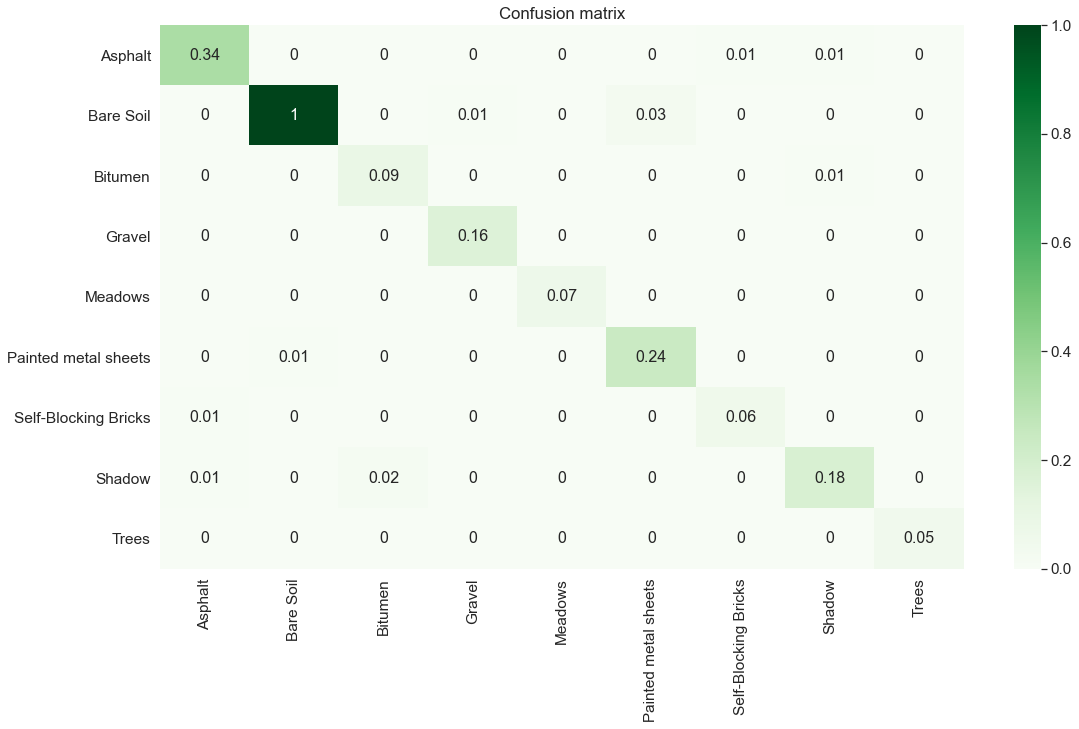

In [15]:
names = ["Asphalt", "Meadows", 
         "Gravel", "Trees", 
         "Painted metal sheets", 
         "Bare Soil", "Bitumen", 
         "Self-Blocking Bricks", 
         "Shadow"]

df_cm = pd.DataFrame(out_pavia, columns=np.unique(names), index = np.unique(names))
plt.figure(figsize=(18, 10))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, cmap="Greens", annot=True, annot_kws={"size": 16}) # font size
plt.title("Confusion matrix")
plt.show()

In [16]:
total_pred_pav = svm_pavia.predict(class_imprt.iloc[:, :-1])
df_pavia_u['class_pred'] = df_pavia_u['class']

# seting the predicted value
df_pavia_u.iloc[class_imprt.index, -1] = total_pred_pav
recompose_image = df_pavia_u.class_pred.to_numpy().reshape(y_pavia_u.shape)

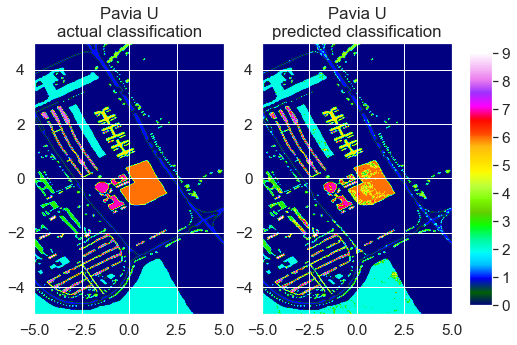

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))
im1 = axes[0].imshow(y_pavia_u, extent=(-5,5,-5,5), aspect='auto', cmap='gist_ncar')
tx1 = axes[0].set_title("Pavia U\nactual classification")
im2 = axes[1].imshow(recompose_image, extent=(-5,5,-5,5), aspect='auto', cmap='gist_ncar')
tx2 = axes[1].set_title("Pavia U\npredicted classification")
# add space for colour bar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
bar = fig.colorbar(im2, cax=cbar_ax, ticks=range(10))